# Multi-agent Collaboration


## Overview

A single agent can usually perform well using a small set of tools to solve a specific task. However, even powerful models like GPT-4 may struggle when given many different tools to solve a complex task.

One way to approach complicated tasks is through a _"divide-and-conquer"_ approach. Create a specialized agent for each task and route tasks to the correct _"expert"_.

The code from this notebook is adapted from the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration). The ideas in this notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

The graph that we'll build will look something like the following diagram:

![multi_agent diagram](img/simple_multi_agent_diagram.png)

**Figure 1**: Image from [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration)

## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Create Agents

The following helper function will help create agents. These agents will then be nodes in the graph.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
)
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import BaseTool
from langchain_core.runnables import RunnableSequence


def create_agent(
    model: BaseChatModel, 
    tools: list[BaseTool], 
    system_message: str
) -> RunnableSequence:
    """
    Create an agent that will be a node in the graph.

    Args:
        model: The LLM that powers this agent.
        tools: List of tools to be called by the LLM.
        system_message: The system message passed to the LLM 
            to configure its behaviour.

    Returns:
        A chain that can be invoked.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, "
                "collaborating with other assistants. "
                "Use the provided tools to progress "
                "towards answering the question. "
                "If you are unable to fully answer, "
                "that's OK, another assistant with "
                "different tools will help where "
                "you left off. Execute what you can "
                "to make progress. If you or any of "
                "the other assistants have the "
                "final answer or deliverable, "
                "prefix your response with FINAL ANSWER "
                "so the team knows to stop. "
                "You have access to the following tools: {tool_names}."
                "\n\n"
                "{system_message}",
            ),
            MessagesPlaceholder(
                variable_name="messages"
            ),
        ]
    )
    prompt = prompt.partial(
        system_message=system_message
    )
    prompt = prompt.partial(
        tool_names=", ".join(
            tool.name for tool in tools
        )
    )
    return (
        prompt 
        | model.bind_tools(tools)
    )

## Define Tools

We will also define some tools that our agents will use.


### Key-Value Store

The stock data will be downloaded as a pandas `DataFrame`. There is no easy way to pass a `DataFrame` between the agents. So, we'll need a key-value store to store the downloaded stock data and later retrieve it using just a key (string).

> LangChain Concepts: [Key-value stores](https://python.langchain.com/v0.2/docs/concepts/#key-value-stores)

In [3]:
from langchain_core.stores import InMemoryStore

data_store = InMemoryStore()

Create a `Stock` data class to represent the downloaded stock data:

In [4]:
from dataclasses import (
    dataclass, 
    field
)
import pandas as pd

@dataclass
class Stock:
    """
    Represents a stock's data that was downloaded from 
    Yahoo! Finance.
    """
    ticker_symbol: str
    """The stock's ticker symbol, e.g., AAPL."""
    
    name: str
    """A short name for the stock, e.g., Apple Inc."""
    
    historical_data: pd.DataFrame = field(
        init=False, 
        repr=False, 
        compare=False,
    )
    """
    A pandas `DataFrame` containing the stock's historical data.
    The `DataFrame` contains columns: 
        `Date`, `Open`, `High`, `Low`, `Close`, `Volume`.
    The `Date` column will be used as the `DatetimeIndex`.
    """

### Fetch historical stock data tool

This tool is used by the `stock_researcher` agent to fetch historical data for a given stock's ticker symbol. This tool uses the [`yfinance`](https://github.com/ranaroussi/yfinance) library to download market data from [Yahoo! finance](https://finance.yahoo.com/).

In [5]:
from typing import Annotated

from langchain_core.tools import tool

import yfinance as yf


@tool
def get_historical_stock_data(
    ticker_symbol: Annotated[
        str, 
        "A ticker symbol is a stock symbol; "
        "an abbreviation of a company's name that "
        "uniquely identifies its publicly traded "
        "shares on stock exchanges. Examples of "
        "ticker symbols are GOOGL for Google, "
        "AMZN for Amazon, MSFT for Microsoft, "
        "AAPL for Apple."
    ],
) -> str:
    """
    Downloads the historical stock data for a given 
    stock ticker symbol.

    Example:
    
        # fetch historical stock data for Apple Inc
        get_historical_stock_data('AAPL')
    """
    # download the stock data from Yahoo! Finance
    stock_data = yf.Ticker(ticker_symbol)

    # create Stock object from downloaded data
    stock = Stock(
        ticker_symbol=ticker_symbol, 
        name=stock_data.info['shortName']
    )
    
    stock.historical_data = stock_data.history(
        # 1 day interval
        interval='1d', 
        # 3 months history
        period='3mo',
        # do NOT Include Dividends and 
        # Stock Splits in results
        actions=False,
    )

    # save the Stock object to a key-value store 
    # to be retrieved later by another agent
    key = ticker_symbol
    data_store.mset([(key, stock)])

    # return a string update for the LLM
    return (
        "Successfully downloaded historical stock "
        f"data for `{ticker_symbol}`.\n\n"
        "A Stock object has been created and "
        "saved to the data store with the key "
        f"'{key}'. Use this key to retrieve the "
        "Stock object from the data store."
    )

Let's try invoking the tool to see what we get back:

In [6]:
from langchain_core.messages import ToolCall

# normally, this would be generated by the LLM
tool_call = ToolCall(
    name="get_historical_stock_data",
    args={
        "ticker_symbol": "SPY"
    },
    id=123,          # required
    type="tool_call" # required
)

tool_result = get_historical_stock_data.invoke(
    input=tool_call
)

In [7]:
tool_result

ToolMessage(content="Successfully downloaded historical stock data for `SPY`.\n\nA Stock object has been created and saved to the data store with the key 'SPY'. Use this key to retrieve the Stock object from the data store.", name='get_historical_stock_data', tool_call_id='123')

Retrieve the `Stock` object from the key-value store:

In [8]:
test_stock = data_store.mget(["SPY"])[0]
test_stock

Stock(ticker_symbol='SPY', name='SPDR S&P 500')

In [9]:
test_stock.historical_data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-26 00:00:00-04:00,563.179993,563.909973,559.049988,560.789978,35788600
2024-08-27 00:00:00-04:00,559.489990,562.059998,558.320007,561.559998,32693900
2024-08-28 00:00:00-04:00,561.210022,561.650024,555.039978,558.299988,41066000
2024-08-29 00:00:00-04:00,560.309998,563.679993,557.179993,558.349976,38715200
2024-08-30 00:00:00-04:00,560.770020,564.200012,557.140015,563.679993,62667800


### Plot Chart Tool

This tool is used by the `chart_generator` agent to plot a chart of a stock's historical data (`Date`, `Open`, `High`, `Low`, `Close`, `Volume`). This tool uses the [`mplfinance`](https://github.com/matplotlib/mplfinance) library which is an extension of [matplotlib](https://matplotlib.org/) for the visualization, and visual analysis of financial data.

In [10]:
import mplfinance as mpf


@tool
def plot_chart(    
    key: Annotated[
        str, 
        "A unique key used to retrieve a "
        "`Stock` object from the data store."
    ]
) -> str:
    """
    Plot a chart of a stock's historical data.

    A key must be provided to retrieve the `Stock` 
    object from the data store. Each `Stock` 
    object is associated with a unique key in 
    the data store.

    Example:

        # Get `Stock` object associated with key `SPY` and
        # plots a chart of the stock's historical data.
        plot_chart(key="SPY")
    """
    # get the Stock object that was saved 
    # earlier from the key-value store
    stock = data_store.mget([key])[0]

    # plot the stock's historical data
    mpf.plot(
        data=stock.historical_data,
        type='candle',
        mav=2,
        mavcolors=['magenta'],
        volume=True,
        title=f'\n{stock.name} ({stock.ticker_symbol})'
    )

    # return a string update for the LLM
    return (
        "Finished plotting chart for "
        f"`{stock.ticker_symbol}`."
    )

Let's try invoking the tool to see what we get back:

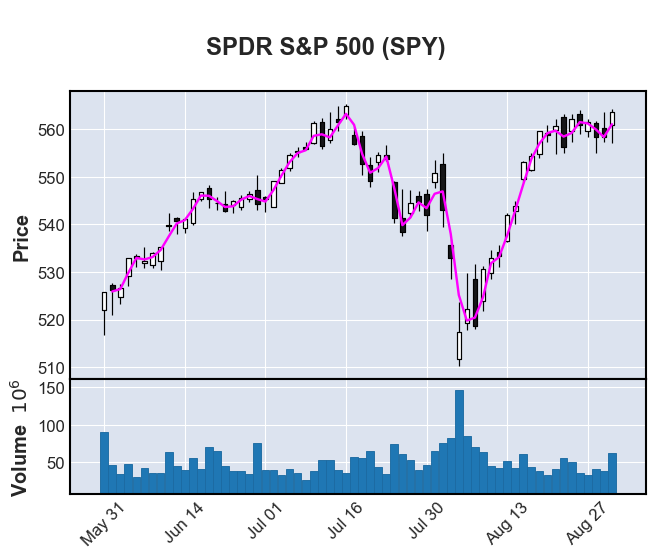

In [11]:
# normally, this would be generated by the LLM
tool_call = ToolCall(
    name="plot_chart",
    args={
        "key": "SPY"
    },
    id=123,          # required
    type="tool_call" # required
)

tool_result = plot_chart.invoke(
    input=tool_call
)

In [12]:
tool_result

ToolMessage(content='Finished plotting chart for `SPY`.', name='plot_chart', tool_call_id='123')

## Create graph

After we've defined the tools for the agents, we'll create the agents and tell them how to talk to each other using LangGraph.

### Define State

First define the state of the graph. This will be a list of messages, a key to track the most recent sender, and a pandas `DataFrame` containing a stock's historical data.

> See LangGraph Concepts:
> * [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)
> * [Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)

In [13]:
import operator
from typing import (
    Annotated, 
    Sequence, 
    TypedDict
)


class AgentState(TypedDict):
    """
    Schema of the graph representing the graph's state.
    """
    messages: Annotated[
        Sequence[BaseMessage], 
        operator.add
    ]
    """List of messages that will be accumulated."""
    
    sender: str
    """The most recent node that sent this state."""

### Define Agent Nodes

Create the chat model (LLM) that will power the agents:

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI

chat_model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
)

Next, let's define the nodes for the agents. To make things easier, we'll create a helper function to create a node for a given agent.

In [15]:
from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable


def agent_node(
    input_state: AgentState, 
    agent: Runnable, 
    name: str
) -> AgentState:
    """
    Create a node on the graph for a given agent.

    Args:
        input_state: Current state of the graph.
        agent: The agent is just a chat model that 
            can call tools.
        name: The name of the node in the graph.
        
    Returns:
        New state of the graph.
    """
    result: BaseMessage = agent.invoke(input_state)
    
    if isinstance(result, ToolMessage):
        pass
    else:
        # ignore message `type`, fix it as `AIMessage`
        # `name` attribute set to agent's name
        result_dict = result.dict(
            exclude={"type", "name"}
        )
        result = AIMessage(
            **result_dict, 
            name=name
        )

    # Output state
    return AgentState(
        messages=[result],
        
        # Keep track of the agent that sent 
        # the most recent message, so that we 
        # know who to route to next.
        sender=name,
    )

#### Stock Researcher Agent

Create the stock researcher agent and its node in the graph. This agent is responsible for fetching historical data of a stock given a stock's ticker symbol. 

In [40]:
from functools import partial


stock_researcher_agent = create_agent(
    model=chat_model,
    tools=[
        get_historical_stock_data
    ],
    system_message=(
        "Given a stock's ticker symbol "
        "(e.g., AAPL for Apple Inc, MSFT for Microsoft Corp, etc.), "
        "your task is to download that stock's historical data. "
        "Another AI assistant will help you with plotting the chart."
    ),
)

# stock_researcher_node(input_state: AgentState) -> AgentState
stock_researcher_node = partial(
    agent_node, 
    agent=stock_researcher_agent, 
    name="stock_researcher"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### Chart Generator Agent

Create the agent that will plot a chart of the stock data. Also, create a node in the graph for this agent.

In [42]:
chart_agent = create_agent(
    model=chat_model,
    tools=[
        plot_chart
    ],
    system_message=(
        "Another AI assistant will download the "
        "stock data for you. Your task is to plot "
        "a chart of the stock data."
    ),
)

chart_generator_node = partial(
    agent_node, 
    agent=chart_agent, 
    name="chart_generator"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


### Define Tool Node

Define a node to run the tools used by the agents.

In [43]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(
    tools=[
        get_historical_stock_data, 
        plot_chart
    ]
)

### Define Routing Function

Define the routing function that is used in the conditional edges of our graph. The routing function decides which node to send the state to next based on the response of the agents.

> See LangGraph Concepts: [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)

In [44]:
from typing import Literal


def router(
    input_state: AgentState
) -> Literal["call_tool", "finish", "continue"]:
    """
    Routes to different nodes based on the 
    agent's actions.

    Args:
        input_state: Current state of the graph.

    Returns:
        One of the following strings:
        - `call_tool`: If agent called a tool.
        - `finish`: If an agent decides that the work is finished.
        - `continue`: If current agent thinks that it does not 
            have the required tools to complete the task and 
            decides to hand over to another agent.
    """
    messages: Sequence[BaseMessage] = input_state["messages"]
    last_message: AIMessage = messages[-1]    

    if last_message.tool_calls:
        # agent called a tool
        return "call_tool"
    
    if "FINAL ANSWER" in last_message.content:
        # agent decides that the job is done
        return "finish"

    # Hand control over to the other agent
    return "continue"

### Build the Graph

We can now put it all together and build the graph.

In [45]:
from langgraph.graph import (
    START, 
    END,
    StateGraph,
)


workflow = StateGraph(
    state_schema=AgentState
)

workflow.add_node(
    node="stock_researcher", 
    action=stock_researcher_node
)
workflow.add_node(
    node="chart_generator", 
    action=chart_generator_node,
)
workflow.add_node(
    node="call_tool", 
    action=tool_node,
)

workflow.add_conditional_edges(
    source="stock_researcher",
    path=router,
    path_map={
        "continue": "chart_generator", 
        "call_tool": "call_tool", 
        "finish": END,
    },
)

workflow.add_conditional_edges(
    source="chart_generator",
    path=router,
    path_map={
        "continue": "stock_researcher", 
        "call_tool": "call_tool", 
        "finish": END,
    },
)

# Each agent node updates the 'sender' field
# the tool calling node does not, meaning
# this edge will route back to the original agent
# who invoked the tool
workflow.add_conditional_edges(
    source="call_tool",
    # state: AgentState -> sender: str
    path=lambda state: state["sender"],
    path_map={
        "stock_researcher": "stock_researcher",
        "chart_generator": "chart_generator",
    }
)

workflow.add_edge(
    start_key=START, 
    end_key="stock_researcher"
)

graph = workflow.compile()

Let's visualize the graph that we've built:

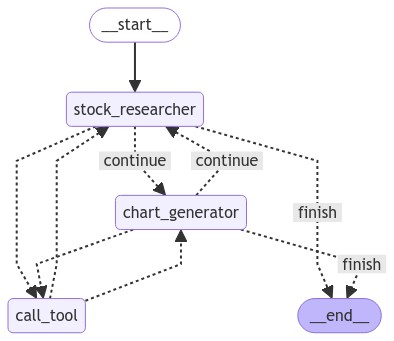

In [46]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=True).draw_mermaid_png()
    )
)

## Execute the Graph

After we have built the graph and compiled it, we can now execute it. Let's have it fetch a stock's historical data and plot a chart for us:

================================ Human Message =================================

1. Fetch the historical stock data for NVIDIA Corp with stock ticker symbol NVDA.
2. Plot a chart of this stock data.
3. Finish.
================================== Ai Message ==================================
Name: stock_researcher
Tool Calls:
  get_historical_stock_data (cb3064b8-a6e9-47e8-b7f2-f2014f023e2d)
 Call ID: cb3064b8-a6e9-47e8-b7f2-f2014f023e2d
  Args:
    ticker_symbol: NVDA
================================= Tool Message =================================
Name: get_historical_stock_data

Successfully downloaded historical stock data for `NVDA`.

A Stock object has been created and saved to the data store with the key 'NVDA'. Use this key to retrieve the Stock object from the data store.
================================== Ai Message ==================================
Name: stock_researcher

I have downloaded the historical stock data for NVDA. I need help plotting the chart.
===================

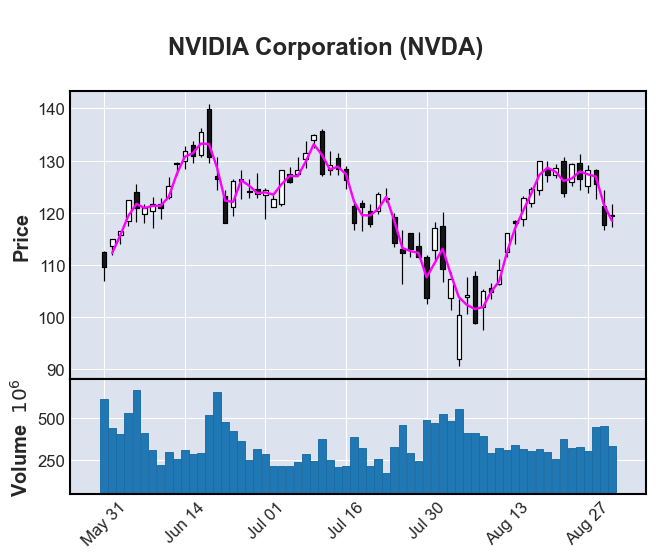

================================= Tool Message =================================
Name: plot_chart

Finished plotting chart for `NVDA`.
================================== Ai Message ==================================
Name: chart_generator

FINAL ANSWER: I have plotted the chart of the historical stock data for NVDA.


In [48]:
events = graph.stream(
    input={
        "messages": [
            HumanMessage(
                content=(
                    "1. Fetch the historical stock data for "
                    "NVIDIA Corp with stock ticker symbol NVDA.\n"
                    "2. Plot a chart of this stock data.\n" 
                    "3. Finish."
                )
            )
        ],
    },
    config={
        # Maximum number of steps to
        # take in the graph
        "recursion_limit": 150
    },
    stream_mode="values",
)

for chunk in events:
    chunk["messages"][-1].pretty_print()

## Conclusion

In this notebook, we have seen how two agents provided with a tool each (i.e., `get_historical_stock_data`, `plot_chart`) can work together to solve a problem that requires the use of all available tools. When one agent does not have the tool to solve a task, it will hand over to another agent that does.